In [10]:
import os
import pandas as pd
import numpy as np
import awkward
import uproot_methods
import sys
sys.path.append('..')

In [2]:
import logging
logging.basicConfig(level=logging.DEBUG, format='[%(asctime)s] %(levelname)s: %(message)s')

In [22]:
def _transform(dataframe, start=0, stop=-1, jet_size=0.8):
    from collections import OrderedDict
    v = OrderedDict()

    df = dataframe.iloc[start:stop]
    def _col_list(prefix, max_particles=200):
        return ['%s_%d'%(prefix,i) for i in range(max_particles)]
    
    _px = df[_col_list('PX')].values
    _py = df[_col_list('PY')].values
    _pz = df[_col_list('PZ')].values
    _e = df[_col_list('E')].values
    
    mask = _e>0
    n_particles = np.sum(mask, axis=1)

    px = awkward.JaggedArray.fromcounts(n_particles, _px[mask])
    py = awkward.JaggedArray.fromcounts(n_particles, _py[mask])
    pz = awkward.JaggedArray.fromcounts(n_particles, _pz[mask])
    energy = awkward.JaggedArray.fromcounts(n_particles, _e[mask])

    p4 = uproot_methods.TLorentzVectorArray.from_cartesian(px, py, pz, energy)
    pt = p4.pt

    jet_p4 = p4.sum()

    # outputs
    _label = df['is_signal_new'].values
    v['label'] = np.stack((_label, 1-_label), axis=-1)
    v['train_val_test'] = df['ttv'].values
    
    v['jet_pt'] = jet_p4.pt
    v['jet_eta'] = jet_p4.eta
    v['jet_phi'] = jet_p4.phi
    v['jet_mass'] = jet_p4.mass
    v['n_parts'] = n_particles

    v['part_px'] = px
    v['part_py'] = py
    v['part_pz'] = pz
    v['part_energy'] = energy

    v['part_pt_log'] = np.log(pt)
    v['part_ptrel'] = pt/v['jet_pt']
    v['part_logptrel'] = np.log(v['part_ptrel'])

    v['part_e_log'] = np.log(energy)
    v['part_erel'] = energy/jet_p4.energy
    v['part_logerel'] = np.log(v['part_erel'])

    v['part_raw_etarel'] = (p4.eta - v['jet_eta'])
    _jet_etasign = np.sign(v['jet_eta'])
    _jet_etasign[_jet_etasign==0] = 1
    v['part_etarel'] = v['part_raw_etarel'] * _jet_etasign


    v['part_phirel'] = p4.delta_phi(jet_p4)
    v['part_deltaR'] = np.hypot(v['part_etarel'], v['part_phirel'])

    v['part_pt_log'] = (v['part_pt_log'] - 1.7) * 0.7
    v['part_e_log'] = (v['part_e_log'] - 2.0) * 0.7
    v['part_logptrel'] = (v['part_logptrel'] - (-4.7)) * 0.7
    v['part_logerel'] = (v['part_logerel'] - (-4.7)) * 0.7
    v['part_deltaR'] = (v['part_deltaR'] - 0.2) * 4.0


    return v

In [23]:
def convert(source, step=None, limit=None):
    df = pd.read_hdf(source, key='table')
    logging.info('Total events: %s' % str(df.shape[0]))
    if limit is not None:
        df = df.iloc[0:limit]
        logging.info('Restricting to the first %s events:' % str(df.shape[0]))
    if step is None:
        step = df.shape[0]
    idx=-1
    while True:
        idx+=1
        start=idx*step
        if start>=df.shape[0]: break
       # if not os.path.exists(destdir):
        #    os.makedirs(destdir)
        # output = os.path.join(destdir, '%s_%d.awkd'%(basename, idx))
        #logging.info(output)
        #if os.path.exists(output):
         #   logging.warning('... file already exist: continue ...')
          #  continue
        v=_transform(df, start=start, stop=start+step)
    return v
       # awkward.save(output, v, mode='x')

In [8]:
srcDir = 'original'
destDir = 'converted'

In [13]:
 cd ..

/home/rd804/particle_transformer


In [83]:
v_converted = convert('data/test.h5')

[2024-03-20 15:45:16,599] INFO: Total events: 404000
/home/rd804/.conda/envs/lorentz/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))


In [66]:
test = np.array(v_converted['part_pt_log'])

In [104]:
def pad_array(array, pad_to=128, constant_value=0):
    if array.shape[0] > pad_to:
        return array[:pad_to]
    else:
        return np.pad(array, ((0, pad_to - array.shape[0])), mode='constant', constant_values=constant_value)


#def pad_features(list, pad_to=128, constant_value=0):
 #   return np.array([pad_array(array, pad_to, constant_value) for array in list])

In [79]:
# padded_array = pad_array(test[1])

In [77]:
#test[1]

In [105]:
# v_converted

In [154]:
def create_padded_array(array, feature_list=['part_pt_log','part_e_log', 'part_logptrel', 'part_logerel', 'part_deltaR', 'part_etarel', 'part_phirel']):
    features = [np.array(array[feature]) for feature in feature_list]
    stacked_padded_features = []

    for feature_index in range(len(features)):
        padded_features = np.array([np.array(pad_array(features[feature_index][event])).reshape(-1,1) for event in range(len(features[feature_index]))])
        stacked_padded_features.append(padded_features)

    stacked_padded_features = np.concatenate(stacked_padded_features, axis=-1)
    return stacked_padded_features


In [155]:
part_features = create_padded_array(v_converted)

In [156]:
part_4momenta = create_padded_array(v_converted, feature_list=['part_px', 'part_py', 'part_pz', 'part_energy'])

In [159]:
part_labels = v_converted['label']

In [162]:
np.save('data/part_features.npy', part_features)
np.save('data/part_4momenta.npy', part_4momenta)
np.save('data/part_labels.npy', part_labels)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
cd ..

/scratch/rd804/particle_transformer


In [5]:
features = np.load('data/converted/tops/train_part_features.npy')

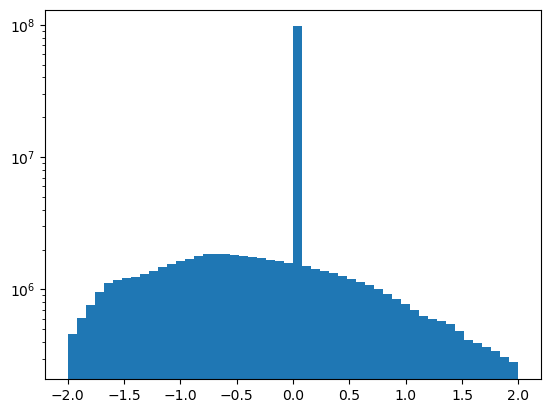

In [12]:
plt.hist(features[...,4].flatten(), bins=50, range=(-2,2))
plt.yscale('log')
plt.show()

In [131]:
stacked_padded_features[0][1][0]-features[0][1][0]

0.29358315

In [ ]:
    for k, names in feature_list.items():
        out[k] = np.stack([_pad(a[n], maxlen=128).to_numpy() for n in names], axis=1)

In [47]:
stacked_features = np.array([np.vstack(feature) for feature in features])

/tmp/ipykernel_2418884/2744876338.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stacked_features = np.array([np.vstack(feature) for feature in features])


ValueError: could not broadcast input array from shape (7,17) into shape (7,)

In [50]:
list_ = [np.vstack(feature) for feature in features]

In [57]:
list_[1].shape

(7, 61)

In [60]:
def _clip(a, a_min, a_max):
    try:
        return np.clip(a, a_min, a_max)
    except ValueError:
        return awkward.unflatten(np.clip(awkward.flatten(a), a_min, a_max), awkward.num(a))

def _pad(a, maxlen, value=0, dtype='float32'):
    if isinstance(a, np.ndarray) and a.ndim >= 2 and a.shape[1] == maxlen:
        return a
    elif isinstance(a, awkward.JaggedArray):
        if a.ndim == 1:
            a = awkward.unflatten(a, 1)
        a = awkward.fill_none(awkward.pad_none(a, maxlen, clip=True), value)
        return awkward.values_astype(a, dtype)
    else:
        x = (np.ones((len(a), maxlen)) * value).astype(dtype)
        for idx, s in enumerate(a):
            if not len(s):
                continue
            trunc = s[:maxlen].astype(dtype)
            x[idx, :len(trunc)] = trunc
        return x


In [ ]:
# conver training file
convert(os.path.join(srcDir, 'train.h5'), destdir=destDir, basename='train_file')

In [ ]:
# conver validation file
convert(os.path.join(srcDir, 'val.h5'), destdir=destDir, basename='val_file')

In [ ]:
# conver testing file
convert(os.path.join(srcDir, 'test.h5'), destdir=destDir, basename='test_file')